# Name frequency notebook

This notebook shows how to create a simple plot 

## Get the data

You need to first download the US baby names database, which is available from kaggle.com.

In [23]:
#!curl https://www.kaggle.com/kaggle/us-baby-names/downloads/database.sqlite.zip -o database.sqlite.zip # Mac
#!wget https://www.kaggle.com/kaggle/us-baby-names/downloads/database.sqlite.zip # Linux/Windows

First, let's set up the environment.  

In [24]:
import os
import sys
import sqlite3
import argparse
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline  


Now make some formatting changes.  

In [25]:
# Plot style
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

Read the database.  

In [26]:
# Read into dataframe from database
if not os.path.isfile('database.sqlite'):
    print " database.sqlite not in current directory. exiting..."
    sys.exit(0)

con = sqlite3.connect("database.sqlite")
df = pd.read_sql("SELECT * from NationalNames",con)

Check the contents.  

In [27]:
df.head()

,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


Check the date range.  

In [28]:
df['Year'].head()

0    1880
1    1880
2    1880
3    1880
4    1880
Name: Year, dtype: int64

In [29]:
df['Year'].tail()

1825428    2014
1825429    2014
1825430    2014
1825431    2014
1825432    2014
Name: Year, dtype: int64

So the data covers years 1880 to 2014.  

In [30]:


def isSlopePositive( name, year, df ):
    # Consider years 5 before and 5 after the year in question 
    # Return true if the average of the 5 years after is greater than
    # the average of the 5 years before.  
    dfShort = df.loc[df[df['Year']>=year-5][df['Year']<=year+5].index.tolist()]
    avgBefore = dfShort[:5].Count.mean()
    avgAfter  = dfShort[6:].Count.mean()
    if avgAfter > avgBefore: 
        return True
    else:
        return False  

def makeNamePlot( names, gender, year=-1 ):

    print "names =", names
    
    df_name = df[ df['Name'].isin(names) ]

    if gender=="B":
        df_name = df_name.groupby('Year', as_index=False).sum()

    else:
        df_name = df_name[ df_name['Gender']==gender ].groupby(['Year','Name'], as_index=False).sum()

        
#    if args.normalize:
#        print " normalizing the counts to peak value of 1"
#        for name in names:
#            maxVal = max(df_name[ df_name['Name']==name ]['Count'])
#            nameReq = df_name['Name']==name
#            df_name.loc[ nameReq, 'Count'] = df_name.loc[ nameReq, 'Count'] / maxVal

    if len(names) > 1:
        fig, ax = plt.subplots()
        labels = []
        for key, grp in df_name.groupby(['Name']):
            ax = grp.plot(ax=ax, kind='line', x='Year', y='Count')
            labels.append(key)
        lines, _ = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')

    else :
        line, = plt.plot(df_name['Year'],df_name['Count'])
        
        if year > 0:
            my_count = df_name[ df_name['Year']==year ]['Count'].iloc[0]
            point, = plt.plot( [ year ], [ my_count ], 'or')

            plt.legend([line, point,], [names[0], year], numpoints=1)
        else:
            plt.legend([line], [names[0]]) 

    plt.xlabel('Year')
    
    plt.savefig( "name_freq.png" )
    print "Saved results in file: "
    
    for name in names:
        if isSlopePositive(name, year, df_name):
            print "The name", name, "was trending upward in year", year  
        else:            
            print "The name", name, "was trending downward in year", year  

names = ['Richard']
Saved results in file: 
The name Richard was trending upward in year 1918


/Users/hwwulsin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


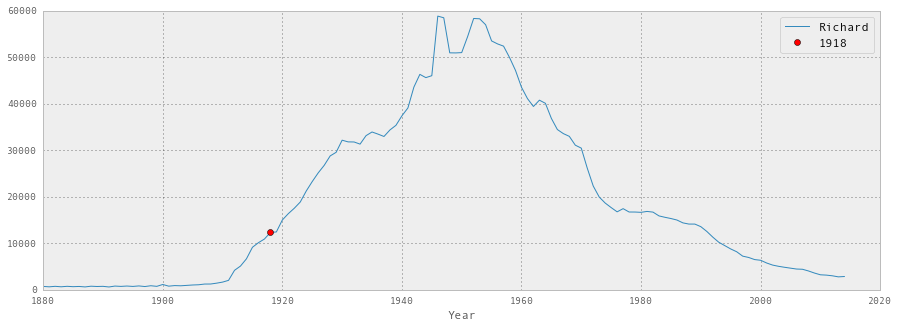

In [31]:
makeNamePlot(["Richard"],"M",1918)  # Richard Feynman was born in 1918  